## Temat:  
### “Fajnie byłoby rozszerzyć nasz serwis o generowanie popularnych playlist – zestawów  pasujących do siebie utworów, których słuchaniem zainteresowane będzie wiele osób”

## Problem biznesowy:
Utworzenie przynajmniej 20 playlist które będą zawierały grupy podobnych utworów o wysokim stopniu popularności w okresie zeszłego tygodnia. Wygenerowane playlisty będą jednakowe dla wszystkich użytkowników.

### Zadania modelowania:
- Określenie stopnia popularności przez rankingowanie utworów na podstawie wskaźnika popularności utworu oraz liczby odtworzeń utworu w sesji użytkowników z okresu jednego tygodnia.
- Tworzenie playlist przez zadanie grupowania utworów podobnych do siebie na podstawie wykonawcy, gatunków w jakich tworzą swoje utwory oraz na podstawie metadanych.

### Założenia:
- playlista składa się z utworów, których łączny czas trwania wynosi co najmniej 1h
- popularne utwory to takie, które posiadają stopień popularności powyżej 75% wszystkich
- bierzemy pod uwagę w modelowaniu popularnych utworów sesję z zeszłego tygodnia

### Kryteria sukcesu:
- biznesowe:
    - Utworzenie co najmniej 20 playlist z popularnymi utworami. Co tydzień będą generowane nowe playlisty.
    - Sprawdzenie czy użytkownicy korzystają z utworzonych playlist przez analizę. Czy i w jakim stopniu kolejność odtwarzanych utworów w danej sesji użytkownika pokrywa się z utworami z którejś playlist. 
   

- analityczne:
    - Porównać predykcje utworów popularnych utworzonej z poprzednich tygodni z sesją użytkowników następującego tygodnia aby sprawdzić czy faktycznie ludzie w następnym tygodniu słuchali najwięcej utworów z naszej predykcji, czyli czy dobrze przewidujemy popularność

## Dane wejściowe

Jednorazowo i przy każdej zmianie:
- artyści
- utwory

Raz w tygodniu dane z zeszłych 2 tygodni:
- sesja użytkowników

Format danych wejściowych do modelu po przekształceniu przedstawiliśmy w dalszej analizie.

Na wyjście dostaniemy Dataframe posiadający 2 kolumny: id utworu oraz numer grupy do której należy.

# Funkcja celu

- Rankingowanie: Lista utworów które posiadają stopień popularności powyżej 75 %, które są wyznaczane na podstawie sesji użytkowników z poprzednich 2 tygodni oraz wskaźnika popularności utworów.

- Grupowanie: Klastry zawierające podobne utwory o łącznej długości ok. jednej godziny. Utwory będą rozdzielane za pomocą wykonawcy, gatunków w jakich tworzą swoje utwory oraz na podstawie metadanych.



# Analiza danych

In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav2/artists.jsonl")
sessions = jsonl2df("datav2/sessions.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")
users = jsonl2df("datav2/users.jsonl")

In [3]:
def get_nulls(df):
    for column in df.columns:
        nan_count = df[column].isna().sum()
        if nan_count:
            print(f'Number of NaN in column {column}: {nan_count}')

## Wykonawcy

In [4]:
artists.head()

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]


In [5]:
artists.describe()

,id,name,genres
count,1667,1667,1667
unique,1667,1667,1357
top,46MWeeHNVMYRIIofQBEX98,BEAM,"[latin, latin hip hop, reggaeton, reggaeton fl..."
freq,1,1,15


Wszystkie id wykonawców są unikalne.

In [6]:
get_nulls(artists)

Wszystkie wiersze wykonawców posiadają gatunku.

In [7]:
artists["id"].value_counts().loc[lambda x: x > 1]

Series([], Name: count, dtype: int64)

# Utwory

In [8]:
tracks.head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.332,0.713,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.321,0.134,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,55,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.156,0.169,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.788,0.590,126.974
4,6kD1SNGPkfX9LwaGd1FG92,Put Your Dreams Away (For Another Day),53,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.152,0.100,90.150


In [9]:
tracks.describe(include=np.object_)

,id,name,id_artist,release_date
count,22412,22412,22412,22412
unique,22412,17727,1418,3907
top,27Y1N4Q4U3EfDU5Ubw8ws2,Animals,06HL4z0CvFAxyc27GXpf02,2013-01-01
freq,1,11,306,268


Istnieją utwory które mają tą samą nazwę ale każdy z nich posiada unikalne id więc będzie można je zidentyfikować.

In [10]:
tracks.describe(include=np.number)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,22412.000000,2.241200e+04,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000
mean,61.375602,2.301383e+05,0.166607,0.599096,0.648017,5.278824,-7.196227,0.082914,0.267758,0.040220,0.193141,0.518000,121.911945
std,8.048246,7.209562e+04,0.372633,0.158259,0.209577,3.558813,3.738098,0.089317,0.276111,0.152828,0.167943,0.244477,29.615254
min,51.000000,3.062200e+04,0.000000,0.000000,0.000103,0.000000,-44.410000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,55.000000,1.914930e+05,0.000000,0.495000,0.508000,2.000000,-8.614500,0.033900,0.029800,0.000000,0.094400,0.325000,97.988000
50%,60.000000,2.206670e+05,0.000000,0.608000,0.672000,5.000000,-6.393000,0.046300,0.165000,0.000003,0.125000,0.512000,120.041000
75%,67.000000,2.562400e+05,0.000000,0.715000,0.816000,8.000000,-4.850000,0.086000,0.455000,0.000523,0.240000,0.713000,140.078000
max,99.000000,4.120258e+06,1.000000,0.980000,0.999000,11.000000,0.642000,0.944000,0.996000,0.998000,0.997000,0.991000,220.099000


## Analiza długości utworu

In [11]:
tracks.sort_values("duration_ms", ascending=False).head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
13345,1saXdvEAafdRzUphXBzSHg,Ocean Waves for Sleep,56,4120258,0,2CgVSpL4tfbUuHmTGS7wF3,2010-07-16,0.0797,0.995,1,-17.379,0.0612,0.9320,0.5620,0.3100,0.00001,84.788
620,1Pt7RPrjEQfzpPA9PS5aZj,Atom Heart Mother,51,1421455,0,0k17h0D3J5VfsdmQ1iZtE9,1970-10-05,0.2660,0.216,9,-16.001,0.0333,0.7850,0.8850,0.0807,0.09190,137.558
12802,1Mzm1CNqVxtwbCYhOo843s,Echoes - 2011 Remastered Version,55,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-05,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
675,7kriFJLY2KOhw5en9iI2jb,Echoes,58,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-11,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
1162,5H8xFHau0x3PI1CssO6EaX,2112: Overture / The Temples Of Syrinx / Disco...,53,1233667,0,2Hkut4rAAyrQxRdof7FVJq,1976-04-01,0.3440,0.790,2,-7.456,0.0983,0.0823,0.0017,0.1870,0.20200,133.186


Czas mocno odstaje od reszty dla id 1saXdvEAafdRzUphXBzSHg i wynosi ponad 1h. Utwory zaraz za tym również mają wysokie wartości, bo wynoszą aż 20 pare minut. Pytanie czy to są już playlisty same w sobie, czy zapętlenia, czy też coś innego?

## Analiza głośności utworu

In [12]:
tracks[tracks["loudness"] > 0]

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
7302,5Ve4qBYAThGLTOva0hhoTa,So Bad,59,325347,1,7dGJo4pcD2V6oG8kP0tJRR,2010-06-18,0.773,0.811,1,0.496,0.0882,0.3040,0.0,0.174,0.774,81.037
11715,5PVv4YALJruehQKyAlwjfE,Must Be The Ganja,56,242907,1,7dGJo4pcD2V6oG8kP0tJRR,2009-05-15,0.728,0.801,1,0.161,0.2970,0.3220,0.0,0.244,0.794,82.657
13912,3E4ZzO4ySupnYypDPXcc3D,Rockstar,65,112273,1,1bAftSH8umNcGZ0uyV7LMg,2018-03-09,0.878,0.855,9,0.642,0.0940,0.0906,0.0,0.174,0.330,123.991
17744,68Y3zzmt2XxzheQVGbbJt4,GENOCIDE,71,632625,1,62F9BiUmjqeXbBztCwiX1U,2019-05-20,0.457,0.965,1,0.457,0.4860,0.0850,0.0,0.697,0.604,170.122


4 wiersze przyjmują wartości dodatnie dla loudnesss które powinno mieć wartości mniejsze równe 0.

In [13]:
get_nulls(tracks)

Wszystkie kolumny nie mają wartości null.

### Wykresy dotyczące utworów

/tmp/ipykernel_26015/4250495543.py:5: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  for column in tracks.select_dtypes(include=['float64', 'int64']).columns.format():


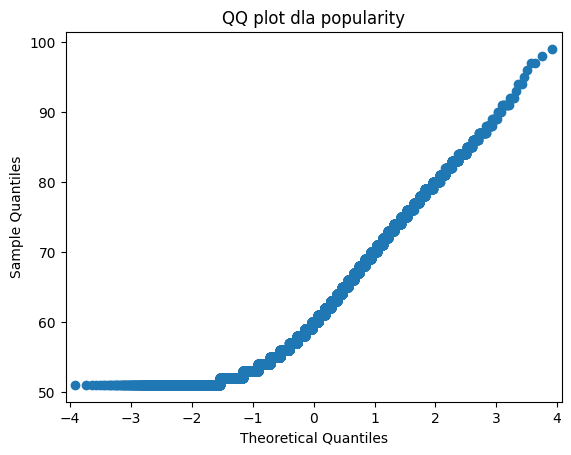

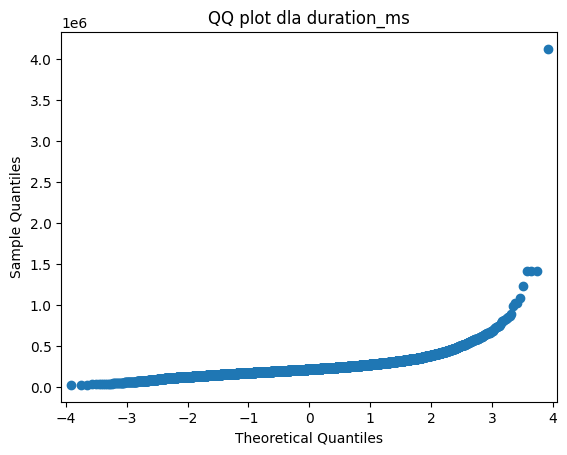

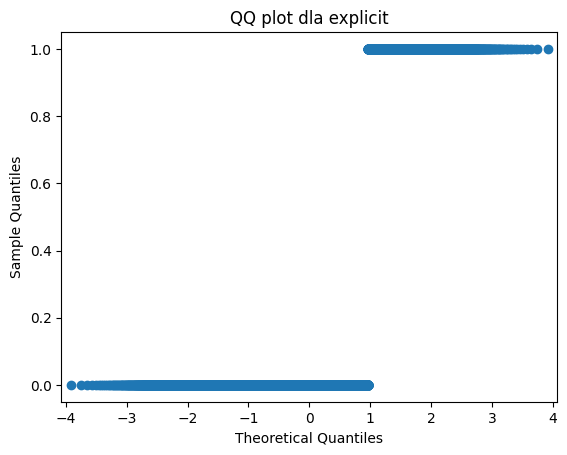

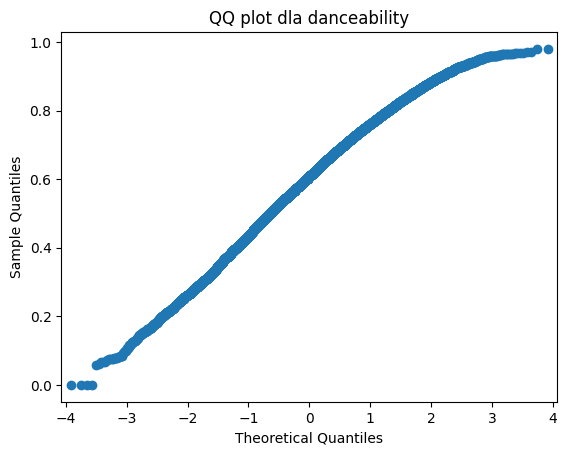

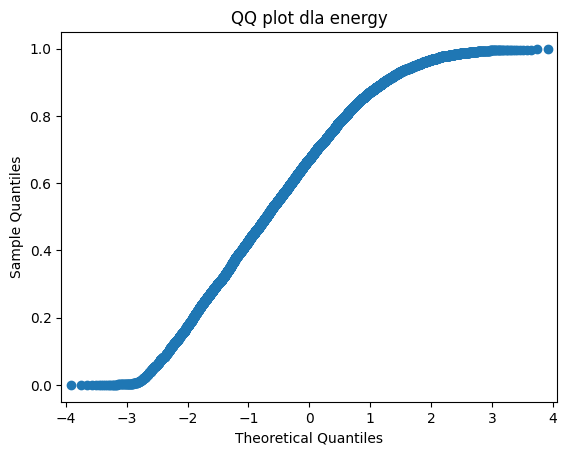

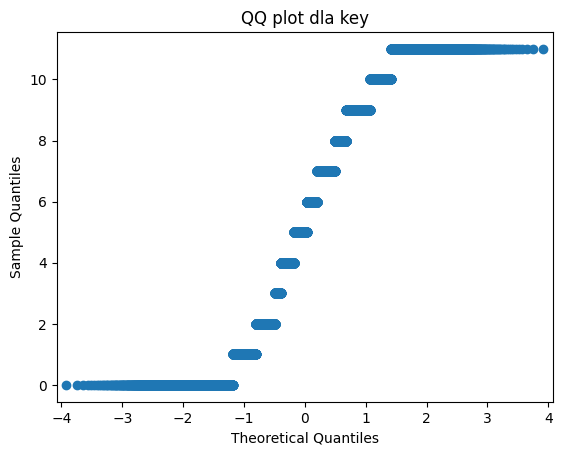

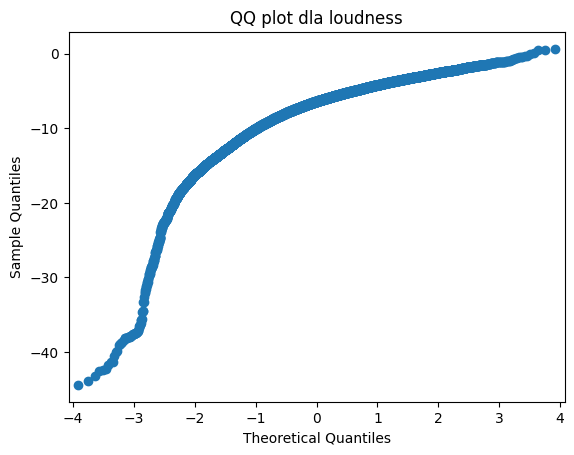

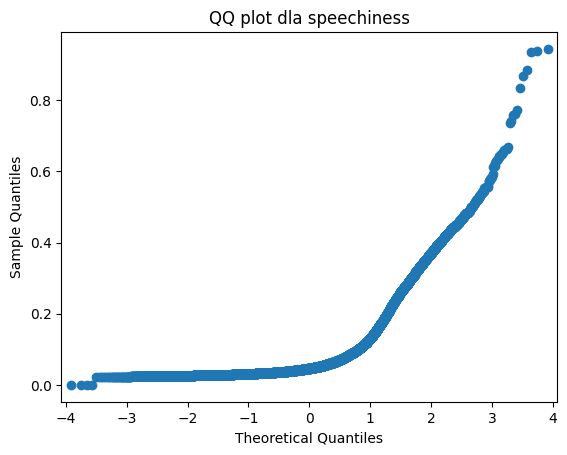

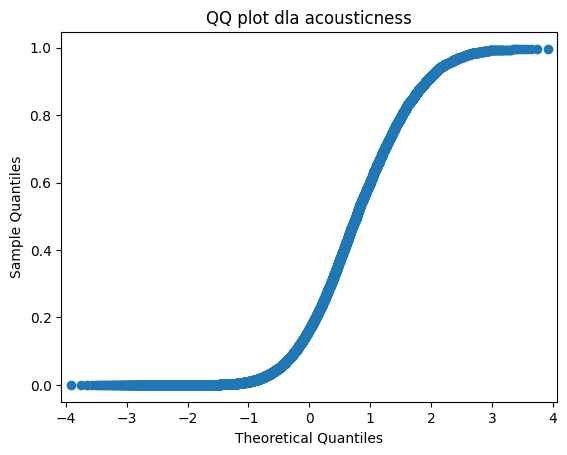

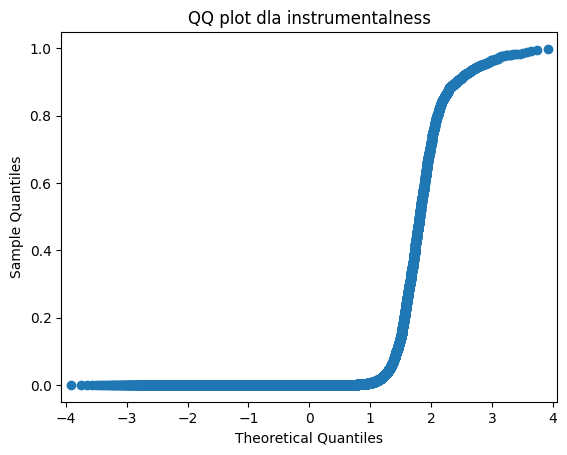

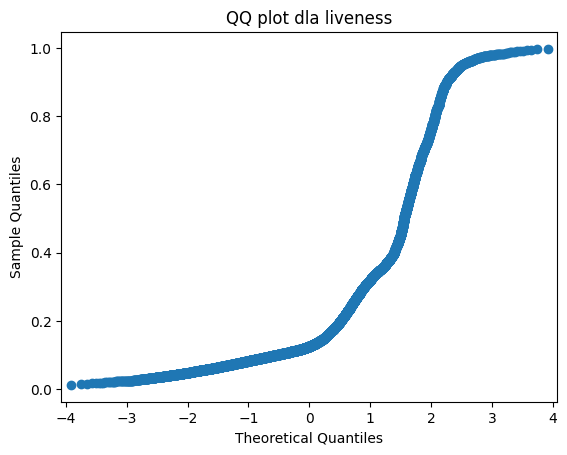

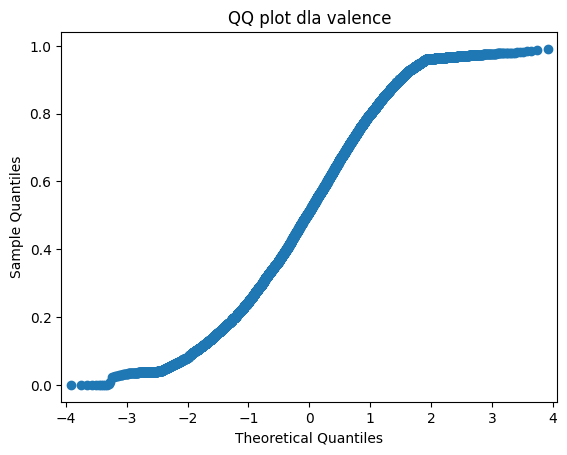

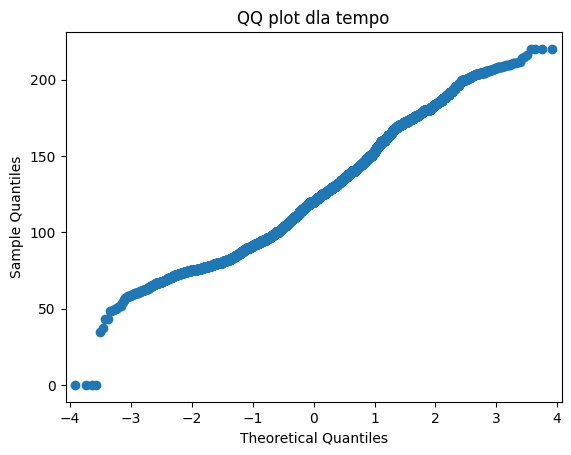

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


for column in tracks.select_dtypes(include=['float64', 'int64']).columns.format():
    fig = sm.qqplot(tracks[column])
    plt.title(f'QQ plot dla {column}')

Aby łatwiej zrozumieć powyższe wykresy kwantylowe poniżej jest wykres dla 10000 próbek wylosowanych z rozkładu jednostajnego U(0, 1).

Jak widać dla części kolumn większość wartości jest poniżej średniej. Jak np. dla: popularności, czasu trwania, mowy, instrumentalności i żywotności. Co ciekawe dane dotyczące tempa utworów tworzą prawie rozkład normalny z wartością średnią około 120 (co w muzyce jest dosyć szybkim tempem). Podobnie dla kolumny dotyczącej taneczności z tym, że wartości są z przedziału (0, 1). Dane dotyczące akustyki, energiczności utworu czy też klucza kształtem przypominają wykres jak dla rozkładu jednostajnego.

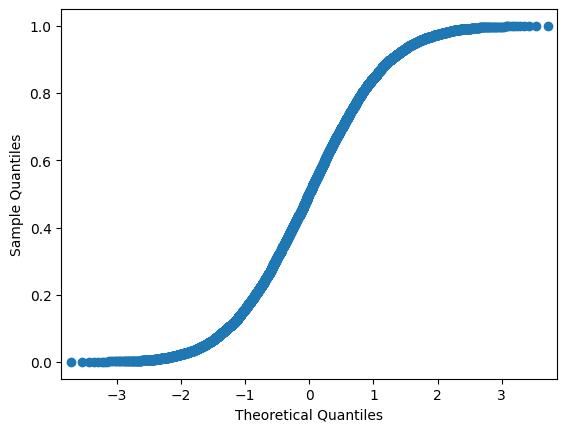

In [16]:
import statsmodels.api as sm
import numpy as np


U = np.random.uniform(0, 1, 10000)
fig = sm.qqplot(U)

# Użytkownicy

In [17]:
users.head()

,user_id,name,city,street,favourite_genres,premium_user
0,101,Dominik Paździora,Wrocław,aleja Jabłoniowa 55/02,"[dance pop, latin, hard rock]",False
1,102,Justyna Mszyca,Poznań,ul. Krótka 710,"[reggaeton, latin arena pop, modern rock]",False
2,103,Kornelia Witka,Gdynia,al. Kościuszki 587,"[rap, art rock, rock]",False
3,104,Jędrzej Kotala,Gdynia,pl. Kossaka 97/86,"[mexican pop, contemporary country, psychedeli...",False
4,105,Karol Kleban,Kraków,ul. Tulipanowa 861,"[rock, adult standards, permanent wave]",False


Użytkownicy nam są nie potrzebni, bo mamy zrobić playlistę proponowaną dla wszystkich, a nie dla danej grupy.

# Sesje

In [18]:
sessions.head()

,session_id,timestamp,user_id,track_id,event_type
0,124,2023-05-21T14:06:46,388,6OjSqRwvwPZy99Z7lA8CIY,play
1,124,2023-05-21T14:09:59.847000,388,None,advertisment
2,124,2023-05-21T14:09:59.847000,388,6mIY6O7uNGgVqOoX70UAYh,play
3,124,2023-05-21T14:14:06.354000,388,1hXtY9yeMAcxZlBvWzjwJn,play
4,124,2023-05-21T14:15:11.725000,388,None,advertisment


In [19]:
sessions["event_type"].value_counts()

event_type
play            3084716
like             995694
skip             868676
advertisment     766094
Name: count, dtype: int64

In [20]:
sessions[sessions["event_type"] == "advertisment"]

,session_id,timestamp,user_id,track_id,event_type
1,124,2023-05-21T14:09:59.847000,388,None,advertisment
4,124,2023-05-21T14:15:11.725000,388,None,advertisment
11,124,2023-05-21T14:33:08.021000,388,None,advertisment
23,125,2023-05-21T23:26:01.628000,633,None,advertisment
28,125,2023-05-21T23:35:13.453000,633,None,advertisment
...,...,...,...,...,...
5715125,272316,2024-05-19T13:57:49.252000,176,None,advertisment
5715157,272319,2024-05-19T14:36:34.852000,878,None,advertisment
5715169,272321,2024-05-19T19:11:02.151000,799,None,advertisment
5715171,272321,2024-05-19T19:11:07.151000,799,None,advertisment


Jeżeli jest wyświetlana reklama to nie ma ona id utworu, dlatego też można w ogóle nie brać tego pod uwagę.

Reklam jest 766094.

In [21]:
get_nulls(sessions)

Number of NaN in column track_id: 766094


In [22]:
nan_count = sessions["track_id"].isna().sum() - sessions[sessions["event_type"] == "advertisment"]["track_id"].isna().sum()
if nan_count:
    print(f'Number of NaN in column {"track_id"}: {nan_count}')

Nie biorąc pod uwagę reklam które nie posiadają informacji na temat utworu, wszystkie wiersze nie posiadają wartości pustych.

# Rankingowanie

### Funkcja celu
Dzielimy sesję ze względu na rok oraz numer tygodnia i następnie dla każdego utworu przyznajemy wartość popularnośći w następujący sposób:
- odtworzony utwór[play]:
    wartość 1
- pominięty utwór[skip]: 
    wartość 0 chyba że utwór został pominięty w przeciągu 1 minuty (Ta sama sesja, te same id utworu). Wtedy będzię odjęte -1.5
- polubiony utwór[like]:
    nie bierzemy pod uwagę ponieważ jest przyznawane dożywotnio dla utworu
- reklama[advertisement]:
    nie bierzemy pod uwagę

In [15]:
sessions_cleaned = sessions[sessions["event_type"].isin(["play", "skip"])].dropna()
sessions_cleaned['timestamp'] = pd.to_datetime(sessions_cleaned['timestamp'])
sessions_cleaned = sessions_cleaned.sort_values(by=['session_id', 'timestamp'])
sessions_cleaned['popularity'] = sessions_cleaned['event_type'].map({'play': 1, 'skip': 0}).astype(np.float64)
epsilon = pd.Timedelta(minutes=1)  # mniej niż minutę jak słucha możemy uznać że mało ciekawe, więc nie popularne

for idx, (_, row) in enumerate(sessions_cleaned.iterrows()):
    if len(sessions_cleaned) - 1 == idx:
        break
    next_row = sessions_cleaned.iloc[idx+1]
    if row['event_type'] == "play" and next_row['event_type'] == 'skip':
        if row['session_id'] == next_row['session_id']:
            diff_time = sessions_cleaned.iloc[idx+1]['timestamp'] - row['timestamp']
            if diff_time < epsilon:
                sessions_cleaned.at[next_row.name, 'popularity'] = -1.5
sessions_cleaned['week'] = sessions_cleaned['timestamp'].dt.isocalendar().week
sessions_cleaned['year'] = sessions_cleaned['timestamp'].dt.isocalendar().year

sessions_popularity = sessions_cleaned.groupby(['year', 'week', 'track_id']).agg({'popularity': 'sum'}).reset_index()
sessions_popularity = sessions_popularity.sort_values(by=['year', 'week', 'popularity'], ascending=[True, True, False])

sessions_popularity

ValueError: unconverted data remains when parsing with format "%Y-%m-%dT%H:%M:%S": ".847000", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
week12 = sessions_popularity[(sessions_popularity["year"]==2023) & (sessions_popularity["week"]==12)]
week13 = sessions_popularity[(sessions_popularity["year"]==2023) & (sessions_popularity["week"]==13)]

In [ ]:
week12.sort_values(by="popularity", ascending=False)

,year,week,track_id,popularity
391,2023,12,5rKtKcIy6ErKf3O7uGfRca,2.0
93,2023,12,1PLMK1ui86iHHG3FM1N7ue,2.0
370,2023,12,5V0YHCNwlupyZYtyXiRSEB,1.0
369,2023,12,5TxdQaqp2Xn9IBTlfq26l7,1.0
368,2023,12,5RsKelNxucrDxgMbZ3vd3W,1.0
...,...,...,...,...
414,2023,12,6ByRaaLxtbMFyIzQob2nDT,-0.5
423,2023,12,6IY2y3kjjLaNbxW4GLiYQR,-0.5
450,2023,12,6gGSSrKMiV2yec1DrqGhhy,-0.5
483,2023,12,7DUh5iszvXQDhhE0ZEtmUe,-0.5


## Podsumowanie analizy danych do rankingowania

Posiadamy 76417 danych do modelowania po usunięciu danych brakujących. Średnio na tydzień mamy ok. 1.5 tysiąca danych, było to by dla nas wystarczająca liczba gdyby nie to że utwory w ciągu tygodnia mają wysoką różnorodność co skutkuje że informacji dla konkretnego utworu mamy zbyt mało. Przykładowo obliczając popularność pomiędzy 12 a 13 tygodniem 2023 roku mieliśmy aż 518 różnych utworów więc dla każdego utworu mieliśmy średnio 3 wierszy, a tak na prawdę większość utworów nie pojawiała się w kolejnym tygodniu wcale. 

W związku z tym zamiast liczyć popularność osobno dla każdego tygodnia, postanowiliśmy dla kolejnych tygodni sumować dotychczasowe odtworzenia utworu (tak jak w funkcji celu). Oprócz tego chcielibyśmy otrzymać większą ilość danych dotyczących sesji użytkowników.

# Grupowanie

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Join tracks with artists
prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")

# Remove rows with empty values
prepared_data = prepared_data.dropna()
prepared_data = prepared_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

# Convert dates to number of days from earliest track
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
min_date = prepared_data['release_date'].min()
prepared_data['release_date'] = (prepared_data['release_date'] - min_date).dt.days

# Scale the attributes to [0, 1]
without = ['id_x', 'duration_ms', 'id_artist', 'genres']
scaled_columns = list(set(prepared_data.columns).difference(without))
prepared_data[scaled_columns] = MinMaxScaler().fit_transform(prepared_data[scaled_columns])

In [17]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_x              22412 non-null  object 
 1   duration_ms       22412 non-null  int64  
 2   explicit          22412 non-null  float64
 3   id_artist         22412 non-null  object 
 4   release_date      22412 non-null  float64
 5   danceability      22412 non-null  float64
 6   energy            22412 non-null  float64
 7   key               22412 non-null  float64
 8   loudness          22412 non-null  float64
 9   speechiness       22412 non-null  float64
 10  acousticness      22412 non-null  float64
 11  instrumentalness  22412 non-null  float64
 12  liveness          22412 non-null  float64
 13  valence           22412 non-null  float64
 14  tempo             22412 non-null  float64
 15  genres            22412 non-null  object 
dtypes: float64(12), int64(1), object(3)
memo

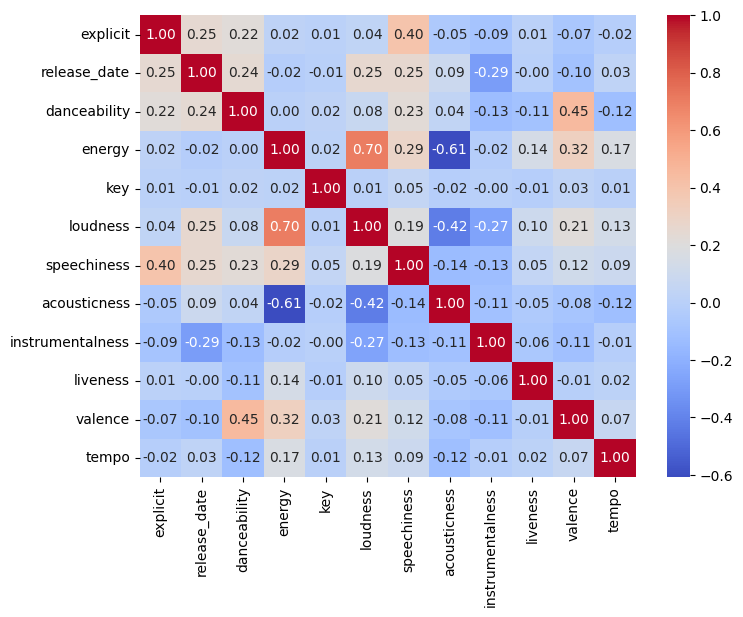

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

params = prepared_data.drop(columns=['genres', 'id_artist', 'duration_ms', 'id_x'])

df_numeric = params.select_dtypes(exclude=['object'])
corr_matrix = params.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Gatunki oraz autorzy zostaną zakodowani za pomocą one-hot encoding

In [21]:
# One-hot encoding of genres
genres_en = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, genres_en], axis=1)

# One-hot encoding of artists
artists_en = pd.get_dummies(prepared_data['id_artist']).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, artists_en], axis=1)

prepared_data = prepared_data.drop(columns=['id_artist', 'genres'])

In [23]:
len(prepared_data.columns)

2211

Otrzymujemy 2211 kolumn po przetworzeniu danych.

## Podsumowanie analizy danych do grupowania

Posiadamy 16438 danych do modelowania z 14 atrybutami do modelowania grupowania oraz dodatkowo 2 dla id utworu i długość utworu. 
Atrybuty do grupowania są ze sobą słabo skorelowane co jest sprzyjające dla modelowaniu.
Po zastosowaniu zadania rankingowania zostanie nam ok. 4 tysięcu utworów.

W naszym założeniu chcieliśmy wygenerować co najmniej 20 playlist godzinnych, średnio utwór ma 230 s. 
```
4000 * 230 / 3600 ~ 250 playlist
```
Mamy więc wystarczającą ilość danych na temat utworów i wykonawców do grupowania.